In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 612ms/step - loss: 0.0024
Average validation loss: 0.6369171142578125
4/4 [==============================] - 6s 629ms/step - loss: 0.0024 - val_loss: 0.6369
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 603ms/step - loss: 0.0016 - val_loss: 0.6369
Average validation loss: 0.5489916801452637
4/4 [==============================] - 8s 615ms/step - loss: 0.0016 - val_loss: 0.5930
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 11s 738ms/step - loss: 0.0011 - val_loss: 0.5930
Average validation loss: 0.4621933698654175
4/4 [==============================] - 11s 754ms/step - loss: 0.0011 - val_loss

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 700ms/step - loss: 7.2410e-07
Average validation loss: 0.0006504771881736815
8/8 [==============================] - 6s 710ms/step - loss: 7.2410e-07 - val_loss: 6.5048e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 676ms/step - loss: 7.0883e-07 - val_loss: 6.5048e-04
Average validation loss: 0.00131893006619066
8/8 [==============================] - 11s 686ms/step - loss: 7.0883e-07 - val_loss: 9.8470e-04
Epoch 3/10
8/8 [==============================] - 17s 684ms/step - loss: 6.9400e-07 - val_loss: 9.8470e-04
Average validation loss: 0.0006208064442034811
8/8 [==============================] - 17s 693ms/step - loss: 6.9400e-07 - val_loss: 8.6340e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 8s 688ms/step - loss: 1.1703e-06
Average validation loss: 0.04487395639201471
12/12 [==============================] - 8s 700ms/step - loss: 1.1703e-06 - val_loss: 0.0449
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 16s 678ms/step - loss: 1.1799e-06 - val_loss: 0.0449
Average validation loss: 0.040883244801079854
12/12 [==============================] - 17s 689ms/step - loss: 1.1799e-06 - val_loss: 0.0429
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 25s 678ms/step - loss: 1.1354e-06 - val_loss: 0.0429
Average validation loss: 0.05091743711257853
12/12 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 11s 681ms/step - loss: 7.4300e-07
Average validation loss: 0.03640448529040441
16/16 [==============================] - 11s 692ms/step - loss: 7.4300e-07 - val_loss: 0.0364
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 22s 686ms/step - loss: 6.9084e-07 - val_loss: 0.0364
Average validation loss: 0.040388895286014304
16/16 [==============================] - 22s 697ms/step - loss: 6.9084e-07 - val_loss: 0.0384
Epoch 3/10
16/16 [==============================] - 33s 692ms/step - loss: 6.7830e-07 - val_loss: 0.0384
Average validation loss: 0.03893360937945545
16/16 [==============================] - 34s 703ms/step - loss: 6.7830e-07 - val_loss: 0.0386
Epoch 4/10
16/16 [==============================] - 45s 700ms/step - loss: 6.9191e-07 - val_loss: 0.0386
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 14s 691ms/step - loss: 4.6629e-07
Average validation loss: 0.06621997551992535
20/20 [==============================] - 14s 702ms/step - loss: 4.6629e-07 - val_loss: 0.0662
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 28s 682ms/step - loss: 5.0258e-07 - val_loss: 0.0662
Average validation loss: 0.077944690361619
20/20 [==============================] - 28s 692ms/step - loss: 5.0258e-07 - val_loss: 0.0721
Epoch 3/10
20/20 [==============================] - 42s 683ms/step - loss: 4.9421e-07 - val_loss: 0.0721
Average validation loss: 0.06348504712805152
20/20 [==============================] - 42s 694ms/step - loss: 4.9421e-07 - val_loss: 0.0692
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weight

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 17s 715ms/step - loss: 5.2237e-07
Average validation loss: 0.06835160156091054
24/24 [==============================] - 17s 726ms/step - loss: 5.2237e-07 - val_loss: 0.0684
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 34s 690ms/step - loss: 4.9285e-07 - val_loss: 0.0684
Average validation loss: 0.05864294432103634
24/24 [==============================] - 34s 700ms/step - loss: 4.9285e-07 - val_loss: 0.0635
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 51s 707ms/step - loss: 4.8857e-07 - val_loss: 0.0635
Average validation loss: 0.07382167192796867
24/24 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 27s 682ms/step - loss: 8.0659e-07
Average validation loss: 0.10615758448839188
40/40 [==============================] - 28s 692ms/step - loss: 8.0659e-07 - val_loss: 0.1062
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 55s 692ms/step - loss: 7.1969e-07 - val_loss: 0.1062
Average validation loss: 0.13450396433472633
40/40 [==============================] - 56s 703ms/step - loss: 7.1969e-07 - val_loss: 0.1203
Epoch 3/10
40/40 [==============================] - 83s 688ms/step - loss: 6.7986e-07 - val_loss: 0.1203
Average validation loss: 0.13535506688058377
40/40 [==============================] - 84s 699ms/step - loss: 6.7986e-07 - val_loss: 0.1253
Epoch 4/10
40/40 [==============================] - 111s 688ms/step - loss: 6.4704e-07 - val_loss: 0.1253
Average validati

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 33s 697ms/step - loss: 4.2196e-07
Average validation loss: 0.08346208371222019
48/48 [==============================] - 34s 707ms/step - loss: 4.2196e-07 - val_loss: 0.0835
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 67s 693ms/step - loss: 3.1716e-07 - val_loss: 0.0835
Average validation loss: 0.10190130428721507
48/48 [==============================] - 68s 703ms/step - loss: 3.1716e-07 - val_loss: 0.0927
Epoch 3/10
48/48 [==============================] - 101s 689ms/step - loss: 2.7406e-07 - val_loss: 0.0927
Average validation loss: 0.08162042995293935
48/48 [==============================] - 101s 700ms/step - loss: 2.7406e-07 - val_loss: 0.0890
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/we

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 716ms/step - loss: 4.4958e-07
Average validation loss: 0.11108780793646085
56/56 [==============================] - 41s 726ms/step - loss: 4.4958e-07 - val_loss: 0.1111
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 696ms/step - loss: 3.5904e-07 - val_loss: 0.1111
Average validation loss: 0.17544558963605336
56/56 [==============================] - 80s 706ms/step - loss: 3.5904e-07 - val_loss: 0.1433
Epoch 3/10
56/56 [==============================] - 120s 704ms/step - loss: 2.8632e-07 - val_loss: 0.1433
Average validation loss: 0.09955860288547617
56/56 [==============================] - 120s 714ms/step - loss: 2.8632e-07 - val_loss: 0.1287
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/we

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 45s 709ms/step - loss: 3.3540e-07
Average validation loss: 0.07359315920621157
64/64 [==============================] - 46s 720ms/step - loss: 3.3540e-07 - val_loss: 0.0736
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 91s 695ms/step - loss: 2.4501e-07 - val_loss: 0.0736
Average validation loss: 0.10440234839916229
64/64 [==============================] - 91s 705ms/step - loss: 2.4501e-07 - val_loss: 0.0890
Epoch 3/10
64/64 [==============================] - 136s 697ms/step - loss: 1.9510e-07 - val_loss: 0.0890
Average validation loss: 0.06820100429467857
64/64 [==============================] - 136s 707ms/step - loss: 1.9510e-07 - val_loss: 0.0821
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/we

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 50s 693ms/step - loss: 2.9660e-07
Average validation loss: 0.06698760535154077
72/72 [==============================] - 51s 703ms/step - loss: 2.9660e-07 - val_loss: 0.0670
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 101s 700ms/step - loss: 2.1580e-07 - val_loss: 0.0670
Average validation loss: 0.05191015483190616
72/72 [==============================] - 102s 710ms/step - loss: 2.1580e-07 - val_loss: 0.0594
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 152s 693ms/step - loss: 1.7131e-07 - val_loss: 0.0594
Average validation loss: 0.06892387941479683
72/72 [==============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 705ms/step - loss: 3.7023e-07
Average validation loss: 0.052769961208105086
80/80 [==============================] - 57s 715ms/step - loss: 3.7023e-07 - val_loss: 0.0528
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 114s 705ms/step - loss: 2.4788e-07 - val_loss: 0.0528
Average validation loss: 0.06216118587180972
80/80 [==============================] - 115s 715ms/step - loss: 2.4788e-07 - val_loss: 0.0575
Epoch 3/10
80/80 [==============================] - 172s 719ms/step - loss: 1.9719e-07 - val_loss: 0.0575
Average validation loss: 0.0671508870087564
80/80 [==============================] - 173s 729ms/step - loss: 1.9719e-07 - val_loss: 0.0607
Epoch 4/10
80/80 [==============================] - 230s 710ms/step - loss: 1.6346e-07 - val_loss: 0.0607
Average val

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 68s 705ms/step - loss: 4.6251e-07
Average validation loss: 0.1592684161538879
96/96 [==============================] - 69s 715ms/step - loss: 4.6251e-07 - val_loss: 0.1593
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 137s 707ms/step - loss: 3.6091e-07 - val_loss: 0.1593
Average validation loss: 0.10057916476701696
96/96 [==============================] - 138s 716ms/step - loss: 3.6091e-07 - val_loss: 0.1299
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 206s 715ms/step - loss: 2.8367e-07 - val_loss: 0.1299
Average validation loss: 0.11818647047039121
96/96 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 711ms/step - loss: 4.9634e-07
Average validation loss: 0.06538250364052753
120/120 [==============================] - 86s 721ms/step - loss: 4.9634e-07 - val_loss: 0.0654
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 171s 705ms/step - loss: 3.2551e-07 - val_loss: 0.0654
Average validation loss: 0.0551761073525995
120/120 [==============================] - 172s 715ms/step - loss: 3.2551e-07 - val_loss: 0.0603
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 257s 705ms/step - loss: 2.5324e-07 - val_loss: 0.0603
Average validation loss: 0.052197222830727696
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 102s 705ms/step - loss: 3.3647e-07
Average validation loss: 0.06415777982652394
144/144 [==============================] - 103s 716ms/step - loss: 3.3647e-07 - val_loss: 0.0642
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 205s 704ms/step - loss: 2.3879e-07 - val_loss: 0.0642
Average validation loss: 0.06817363652711113
144/144 [==============================] - 206s 714ms/step - loss: 2.3879e-07 - val_loss: 0.0662
Epoch 3/10
144/144 [==============================] - 307s 703ms/step - loss: 1.9651e-07 - val_loss: 0.0662
Average validation loss: 0.05870004927015139
144/144 [==============================] - 309s 713ms/step - loss: 1.9651e-07 - val_loss: 0.0637
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 110s 689ms/step - loss: 1.6288e-07
Average validation loss: 0.08145423219539225
160/160 [==============================] - 112s 699ms/step - loss: 1.6288e-07 - val_loss: 0.0815
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 222s 688ms/step - loss: 1.3229e-07 - val_loss: 0.0815
Average validation loss: 0.05725650632521138
160/160 [==============================] - 223s 698ms/step - loss: 1.3229e-07 - val_loss: 0.0694
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 334s 690ms/step - loss: 1.1226e-07 - val_loss: 0.0694
Average validation loss: 0.0719612937187776
160/160 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 139s 694ms/step - loss: 6.7838e-07
Average validation loss: 0.08693130297586321
200/200 [==============================] - 141s 703ms/step - loss: 6.7838e-07 - val_loss: 0.0869
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 279s 692ms/step - loss: 4.4197e-07 - val_loss: 0.0869
Average validation loss: 0.0629002923052758
200/200 [==============================] - 281s 701ms/step - loss: 4.4197e-07 - val_loss: 0.0749
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 420s 694ms/step - loss: 3.3285e-07 - val_loss: 0.0749
Average validation loss: 0.06446013526059687
200/200 [===============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:46 - loss: 2.6288e-08

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 171s 712ms/step - loss: 2.7442e-07
Average validation loss: 0.08170294065106039
240/240 [==============================] - 173s 722ms/step - loss: 2.7442e-07 - val_loss: 0.0817
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 343s 706ms/step - loss: 2.1833e-07 - val_loss: 0.0817
Average validation loss: 0.06883341678573439
240/240 [==============================] - 345s 716ms/step - loss: 2.1833e-07 - val_loss: 0.0753
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 515s 709ms/step - loss: 1.7424e-07 - val_loss: 0.0753
Average validation loss: 0.08369369190186263
240/240 [==============

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.11020056491717696, 0.03285067535405688, 0.07087031554981119, 0.06688064629241125, 0.07031350927939638, 0.07415091226653507, 0.12122715523652733, 0.10222488491330296, 0.09971030215632969, 0.07982958235952538, 0.06234480360005464, 0.05779579666373319, 0.07342345048188387, 0.06115937006706373, 0.057684501653032676, 0.049598679445800375, 0.06019552935934625, 0.05823562814233203]
std_val_losses =  [0.17925609693124586, 0.02273470037458312, 0.03303171491371851, 0.02086307423470922, 0.011106641067461374, 0.02008981188732504, 0.05736165436886119, 0.054451297221422904, 0.03416234732604026, 0.02222134042208663, 0.010557927899360525, 0.009287609203532202, 0.023789127003871587, 0.017414488080721068, 0.008693575164423569, 0.010570172165351435, 0.011861118696081583, 0.013177117612207396]


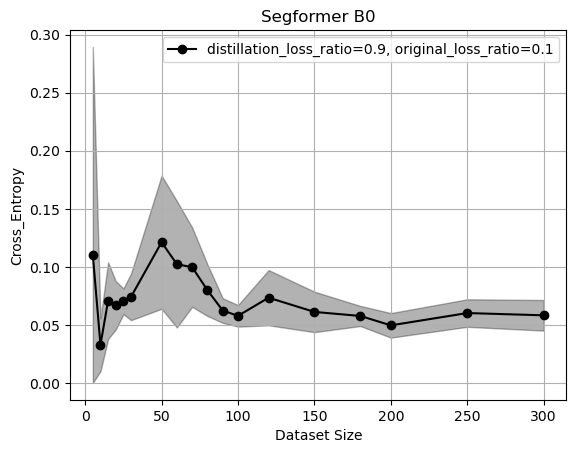

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()